## LockSense Image Classification

#### Model Selection: Transfer Learning

- Rationale: Insufficient data to train a full model from scratch
- Considerations: Need to find a lightweight model

Links/References:
- [All Keras models](https://keras.io/api/applications/)
- Keras documentation: [Transfer Learning](https://keras.io/guides/transfer_learning/)

Utility functions and constants.

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, plot_name):
    # Visualize history
    # Plot history: Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('%s (Loss)' % plot_name)
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Plot history: Accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('%s (Accuracy)' % plot_name)
    plt.ylabel('Accuracy value (%)')
    plt.xlabel('No. epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [ ]:
from tensorflow.keras.models import load_model, Model
import numpy as np
import matplotlib.pyplot as plt

images_per_row = 16

def get_layer_outputs_and_names(model, num_selected_layers):
    selected_layers = model.layers[:num_selected_layers]
    layer_outputs = [layer.output for layer in selected_layers] 
    layer_names = [layer.name for layer in selected_layers]
    return layer_outputs, layer_names

def display_image_activations(layer_outputs, layer_names, activations, selected_image):
    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[selected_image,
                                                :, :,
                                                col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                            row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


# TODO: refactor this to avoid repeated computation when checking multiple images
def visualise_layers(model, num_selected_layers, test_x, selected_image):
    layer_outputs, layer_names = get_layer_outputs_and_names(model, num_selected_layers)

    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(test_x) 

    display_image_activations(layer_outputs, layer_names, activations, selected_image)


In [ ]:
num_classes = 3

input_shape=(224, 224, 3)
target_size=(224, 224)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_datasets(train_path, validation_path, target_size):
    # Include data augmentation techniques
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=(0.5, 1.5),
		rotation_range=20,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Resize to the required input shape
    batch_size = 8
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, validation_generator


def model_callbacks(model_file, patience=10):
    checkpoint = ModelCheckpoint(model_file)
    earlystopping = EarlyStopping(min_delta=0.001, patience=patience)

    return [checkpoint, earlystopping]


#### Hyperparameter Tuning

Documentation:
- [Keras Tuner Tutorial](https://www.tensorflow.org/tutorials/keras/keras_tuner)
- [Tuner class](https://keras.io/api/keras_tuner/tuners/)

In [ ]:
import keras_tuner as kt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import os.path

HYPERRESNET_MODEL_FILE = "hyperresnet.hd5"

num_classes = 3
num_hidden = 128

input_shape=(224, 224, 3)
target_size=(224, 224)

batch_size = 8

def create_datasets(train_path, validation_path):
    # Include data augmentation techniques
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=(0.5, 1.5),
		rotation_range=20,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Resize to the required input shape
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        # save_to_dir="augmented_images/"
    )
    validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, validation_generator


def model_builder(hp):
    base_model = MobileNetV2(
        include_top = False, 
        weights = 'imagenet',
        input_shape=input_shape)

    # Recursively make all layers non-trainable
    base_model.trainable = False

    # Hyperparameters
    hp_hidden_units = hp.Int('hidden', min_value=32, max_value=512, step=32, default=128)
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.9, step=0.1, default=0.9)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4], default=1e-4)
    hp_rho = hp.Float('rho', min_value=0.75, max_value=0.95, step=0.05, default=0.9)

    # Build dense layers for the new model
    inputs = base_model.input
    # Ensure that the base model always runs in inference mode in case of BatchNormalization layers
    x = base_model(inputs, training=False)

    x = GlobalAveragePooling2D()(x)
    x = Dense(hp_hidden_units, activation='relu')(x)
    x = Dropout(hp_dropout)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs = predictions)

    model.compile(
        optimizer=RMSprop(learning_rate=hp_learning_rate, rho=hp_rho), 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )

    return model


def model_callbacks(model_file, patience=10):
    # checkpoint = ModelCheckpoint(model_file, monitor='val_loss', save_best_only=True)
    earlystopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    return [earlystopping]


def train(model, callbacks, train_generator, validation_generator, epochs=20):
    history = model.fit(
        train_generator,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=validation_generator,
        validation_steps=10
    )
    return history


tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=50,
    directory='hyperband_search',
    project_name="mobilenet_transfer"
)
tuner.search_space_summary()

train_generator, validation_generator = create_datasets(
    train_path='datasets/train', 
    validation_path='datasets/test')

callbacks = model_callbacks(HYPERRESNET_MODEL_FILE, patience=5)

tuner.search(
    train_generator,
    callbacks=callbacks,
    validation_data=validation_generator
)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(best_hps)


Trial 90 Complete [00h 01m 36s]
val_accuracy: 0.8701298832893372

Best val_accuracy So Far: 0.9025974273681641
Total elapsed time: 01h 18m 25s
INFO:tensorflow:Oracle triggered exit


In [ ]:
print(
    "hidden: %d, dropout: %.1f, learning_rate: %f, rho: %.1f" % 
    (best_hps.get("hidden"), best_hps.get("dropout"), best_hps.get("learning_rate"), best_hps.get("rho"))
)

hidden: 384, dropout: 0.4, learning_rate: 0.010000, rho: 0.9


In [ ]:
tuner.results_summary()

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
model.summary()

history = model.fit(train_generator, epochs=50, validation_data=validation_generator)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 384)               491904    
_________________________________________________________________
dropout (Dropout)            (None, 384)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1155      
Total params: 2,751,043
Trainable params: 493,059
Non-trainable params: 2,257,984
_____________________________________________

TypeError: plot_history() missing 1 required positional argument: 'plot_name'

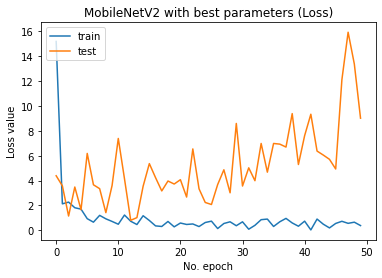

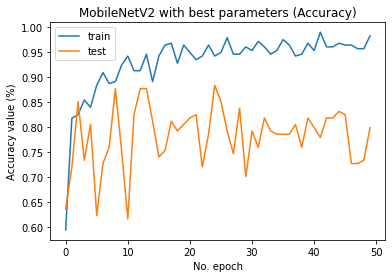

In [ ]:
plot_history(history, "MobileNetV2 with best parameters")

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_generator, epochs=best_epoch, validation_data=validation_generator)

Epoch 1/25
35/35 [==============================] - 11s 256ms/step - loss: 31.4685 - accuracy: 0.3970 - val_loss: 3.3960 - val_accuracy: 0.6753
Epoch 2/25
35/35 [==============================] - 8s 239ms/step - loss: 1.1405 - accuracy: 0.8181 - val_loss: 1.2102 - val_accuracy: 0.7013
Epoch 3/25
35/35 [==============================] - 8s 236ms/step - loss: 0.9170 - accuracy: 0.7860 - val_loss: 3.2539 - val_accuracy: 0.5584
Epoch 4/25
35/35 [==============================] - 9s 250ms/step - loss: 1.2190 - accuracy: 0.7987 - val_loss: 4.7633 - val_accuracy: 0.6299
Epoch 5/25
35/35 [==============================] - 8s 235ms/step - loss: 1.0795 - accuracy: 0.8668 - val_loss: 1.3809 - val_accuracy: 0.7208
Epoch 6/25
35/35 [==============================] - 8s 235ms/step - loss: 1.0703 - accuracy: 0.8392 - val_loss: 3.0585 - val_accuracy: 0.7338
Epoch 7/25
35/35 [==============================] - 8s 235ms/step - loss: 0.5861 - accuracy: 0.9444 - val_loss: 1.4799 - val_accuracy: 0.7403
Epoc

In [ ]:
# TODO: get proper test data for this
_, test_generator = create_datasets(train_path='datasets/train', validation_path='datasets/test-backup')

eval_result = hypermodel.evaluate(test_generator)
print("[test loss, test accuracy]:", eval_result)

Found 274 images belonging to 3 classes.
Found 100 images belonging to 3 classes.
13/13 [==============================] - 2s 127ms/step - loss: 0.4194 - accuracy: 0.9800
[test loss, test accuracy]: [0.4193587899208069, 0.9800000190734863]


#### MobileNetV2 (Previous Version)

[Documentation](https://keras.io/api/applications/mobilenet/), for reference.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 2,422,339
Trainable params: 164,355
Non-trainable params: 2,257,984
___________________________________________

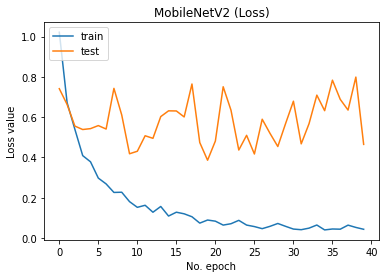

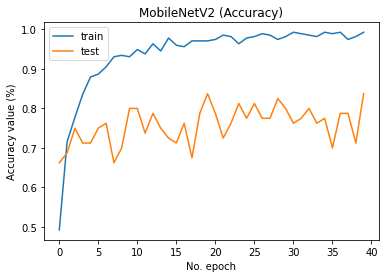

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import os.path

MOBILENET_MODEL_FILE = "mobilenet-transfer-2.hd5"

num_classes = 3
num_hidden = 128

input_shape=(224, 224, 3)
target_size=(224, 224)

batch_size = 8

# Create a model if none exists. Freezes all training except in 
# newly attached output layers. We can specify the number of nodes
# in the hidden penultimate layer, and the number of output categories.

def create_model(num_hidden, num_classes):
    base_model = MobileNetV2(
        include_top = False, 
        weights = 'imagenet',
        input_shape=input_shape)

    # Recursively make all layers non-trainable
    base_model.trainable = False

    # Build dense layers for the new model
    inputs = base_model.input
    # Ensure that the base model always runs in inference mode in case of BatchNormalization layers
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_hidden, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs = predictions)

    return model


# Loads an existing model file, then sets only the last 3 layers
# (which we added above) to trainable.

def load_existing(model_file):
    model = load_model(model_file)

    # Set only last 4 layers as trainable
    num_trainable_layers = len(model.layers) - 4
    
    for layer in model.layers[:num_trainable_layers]:
        layer.trainable = False
    
    for layer in model.layers[num_trainable_layers:]:
        layer.trainable = True

    return model


def load_or_create_model(model_file):
    if os.path.exists(model_file):
        print("\n*** Existing model file found at %s. Loading.***\n\n" % model_file)
        model = load_existing(model_file)
    else:
        print("\n*** Creating new model.***\n\n")
        model = create_model(num_hidden, num_classes)

    return model


def create_datasets(train_path, validation_path):
    # Include data augmentation techniques
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=(0.5, 1.5),
		rotation_range=20,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Resize to the required input shape
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        save_to_dir="augmented_images/"
    )
    validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, validation_generator


def model_callbacks(model_file, patience=10):
    checkpoint = ModelCheckpoint(model_file, monitor='val_loss', save_best_only=True)
    earlystopping = EarlyStopping(
        monitor='val_loss', min_delta=0.001, patience=patience, 
        restore_best_weights=True)

    return [checkpoint, earlystopping]


def train(model, callbacks, train_generator, validation_generator, epochs=20):
    model.compile(
        optimizer=RMSprop(learning_rate=0.0001, rho=0.8), 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )

    history = model.fit(
        train_generator,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=validation_generator,
        validation_steps=10
    )

    return history

model = create_model(num_hidden, num_classes)
model.summary()

train_generator, validation_generator = create_datasets(
    train_path='datasets/train', 
    validation_path='datasets/test')

callbacks = model_callbacks(MOBILENET_MODEL_FILE, patience=20)

history = train(
    model, 
    callbacks,
    train_generator, 
    validation_generator, 
    epochs=50)
plot_history(history, 'MobileNetV2')


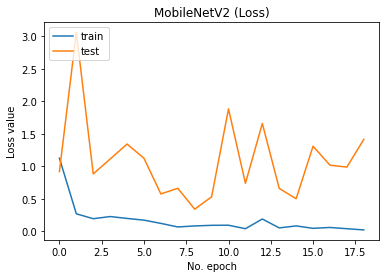

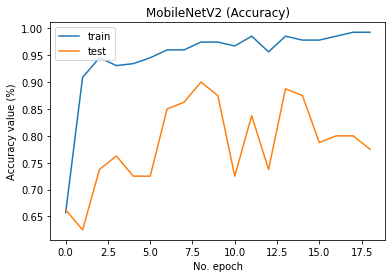

Epoch 1/10
35/35 [==============================] - 13s 252ms/step - loss: 0.0624 - accuracy: 0.9726 - val_loss: 0.4852 - val_accuracy: 0.8500
Epoch 2/10
23/35 [==================>...........] - ETA: 2s - loss: 0.0095 - accuracy: 1.0000

KeyboardInterrupt: 

In [ ]:
def train_finetune(model, callbacks, train_generator, validation_generator, epochs=20):
    # Train last two layers for fine tuning
    # TODO: figure out how many layers to train
    for layer in model.layers[:249]:
        layer.trainable = False
    for layer in model.layers[249:]:
        layer.trainable = True

    model.compile(
        optimizer=SGD(lr=0.00001, momentum=0.9), 
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    history = model.fit(
        train_generator,
        # Let steps per epoch be decided automatically
        # steps_per_epoch=int(steps/batch_size), # each step is one batch
        epochs=epochs,
        callbacks=callbacks,
        validation_data=validation_generator,
        validation_steps=10
    )

    return history

history = train_finetune(model, callbacks, train_generator, validation_generator, epochs=10)
plot_history(history, 'MobileNetV2 fine-tuning')


We can also visualise the output at each step.

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/shared-libs/python3.7/py/lib/python3.7/site-packages/matplotlib/tight_bbox.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/shared-libs/python3.7/py/lib/python3.7/site-packages/matplotlib/tight_bbox.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/shared-libs/python3.7/py/lib/python3.7/site-packages/matplotlib/patches.py:769: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
/shared-libs/python3.7/py/lib/python3.7/site-packages/matplotlib/transforms.py:20

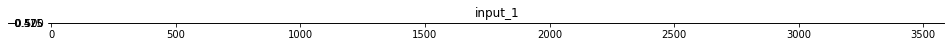

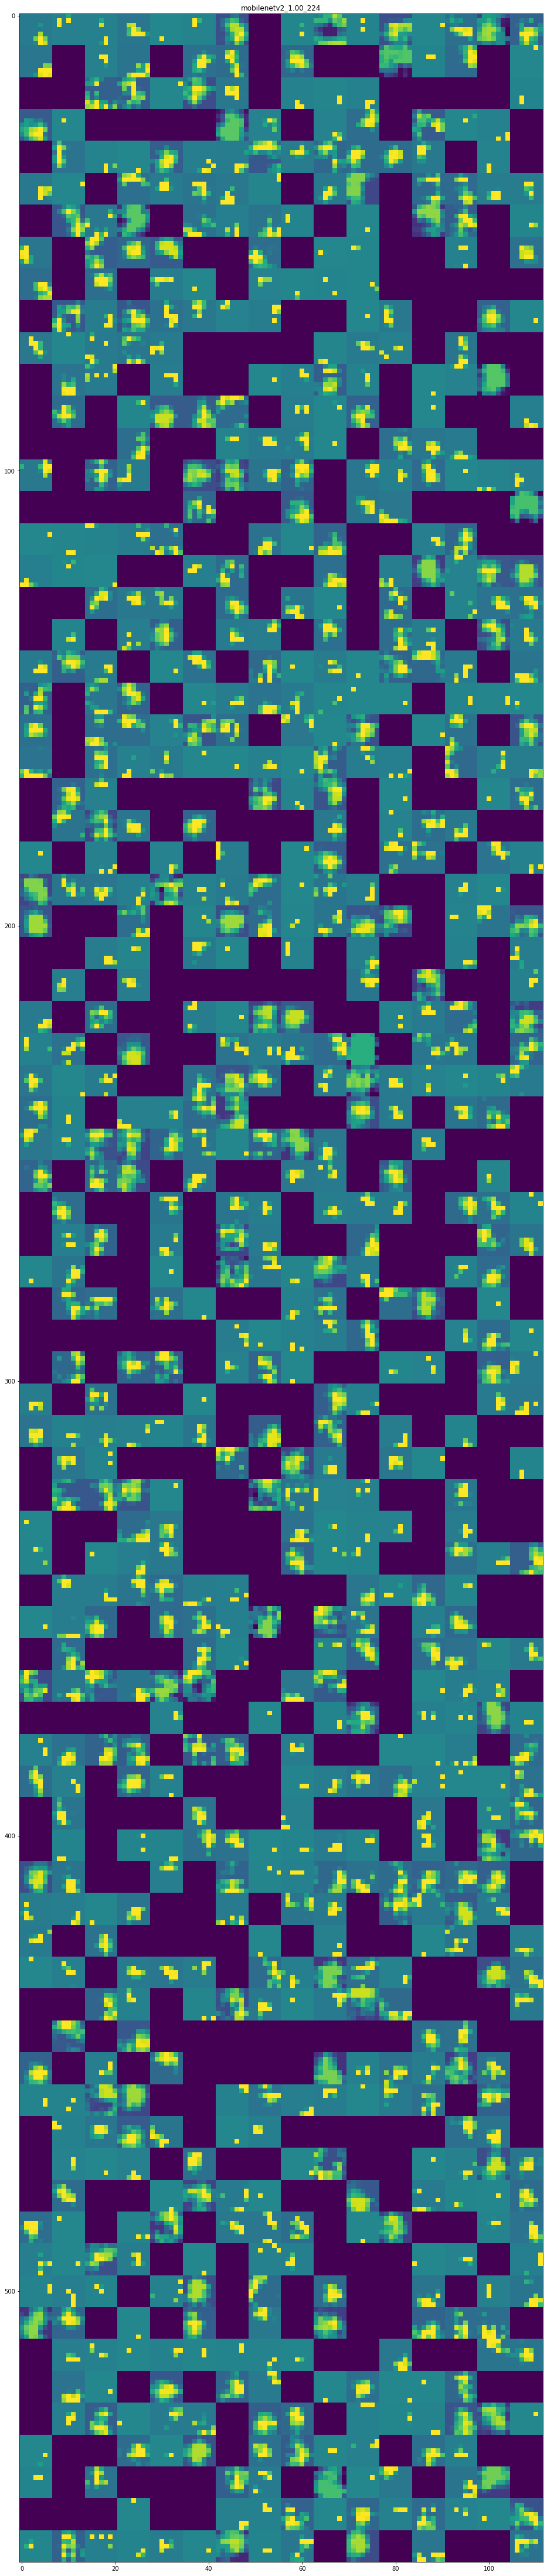

In [ ]:
from numpy import expand_dims
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

model = load_model(MOBILENET_MODEL_FILE)

TEST_IMG_PATH = './datasets/test/lock-n-key/IMG_2934.jpg'
test_img = Image.open(TEST_IMG_PATH).resize(target_size)
data = img_to_array(test_img)
sample = expand_dims(data, 0)

visualise_layers(model, 2, [sample], 0)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ddd5f9cd-14c1-4462-aac1-a464a84065be' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>